#### *Goal*
Build model to predict taxi trip time.
We will be using NYC For Hire Taxi trip records. 

[Data can be found here](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import xgboost

pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-trips")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-trips', tags={}>

In [4]:
sns.set_style("white")

In [9]:
columns=[
'hvfhs_license_num',
'pickup_datetime',
'dropoff_datetime', 
'PULocationID', 
'DOLocationID', 
'trip_miles',
'trip_time', 
'tips']

In [20]:
training_data = pd.read_parquet(
    "data/fhvhv_tripdata_2021-01.parquet",
    engine="pyarrow",
    columns=columns)

In [11]:
testing_data = pd.read_parquet(
    "data/fhvhv_tripdata_2021-01.parquet",
    engine="pyarrow",
    columns=columns)

In [26]:
def prep_taxi_data(df):
    return (df
            .assign(
                trip_time = df["trip_time"]/60,
                **{c:lambda df_, c=c:pd.to_datetime(df_[c], unit="ns", errors="coerce") for c in ["pickup_datetime","dropoff_datetime"]},
                day_of_week = lambda df_: df_["pickup_datetime"].dt.day_name(),
                hour_of_day = lambda df_: df_["pickup_datetime"].dt.hour,
                hour_of_day_sin = lambda df_: np.sin(df_["hour_of_day"]*(2*np.pi/24))
                hour_of_day_cos = lambda df_: np.cos(df_["hour_of_day"]*(2*np.pi/24))
                **{c:lambda df_, c=c:df_[c].astype("category") for c in ["PULocationID","DOLocationID","hvfhs_license_num","hour_of_day"]}
            
                
            )
          
           

    )

In [27]:
training_data = prep_taxi_data(training_data)

In [28]:
training_data.head()

,hvfhs_license_num,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,tips,day_of_week,hour_of_day,hour_of_day_sin
0,HV0003,2021-01-01 00:33:44,2021-01-01 00:49:07,230,166,5.260,15.383,0.000,Friday,0,0.000
1,HV0003,2021-01-01 00:55:19,2021-01-01 01:18:21,152,167,3.650,23.033,0.000,Friday,0,0.000
2,HV0003,2021-01-01 00:23:56,2021-01-01 00:38:05,233,142,3.510,14.150,0.940,Friday,0,0.000
3,HV0003,2021-01-01 00:42:51,2021-01-01 00:45:50,142,143,0.740,2.983,0.000,Friday,0,0.000
4,HV0003,2021-01-01 00:48:14,2021-01-01 01:08:42,143,78,9.200,20.467,0.000,Friday,0,0.000


In [32]:
data = pd.DataFrame()

training_months = list(pd.period_range(start="2019-01-01", end="2022-01-01", freq="M").astype(str))

In [37]:
for ym in training_months:
   download_parquet_to_df(year_month=ym, taxi_type="fhv")

ArrowInvalid: Casting from timestamp[us] to timestamp[ns] would result in out of bounds timestamp: 33106123800000000

In [6]:
fhv_jan21 = download_parquet_to_df(year_month="2021-01", taxi_type="fhv")

In [7]:
fhv_feb21 = download_parquet_to_df(year_month="2021-02", taxi_type="fhv")

In [19]:
fhv_feb21["DOlocationID"].isna().sum()/fhv_feb21.shape[0]

0.14681813100611743

*Calculate trip time which is our variable of interest*

We will calculate as duration in minutes (min) based on the difference between pickup datetime and dropoff datetime

In [8]:
def calculate_trip_duration(df, pickup_datetime, dropoff_datetime):
    trip_duration = (
        (df[dropoff_datetime] - df[pickup_datetime]) / pd.to_timedelta('1 min')
    )
    return trip_duration


In [28]:
fhv_jan21["trip_duration"] = calculate_trip_duration(fhv_jan21, "pickup_datetime", "dropOff_datetime")

Check the distribution of trip times we just calculated

In [29]:
fhv_jan21["trip_duration"].describe(percentiles=[0.5, 0.85, 0.9, 0.95,0.98, 0.99]).reset_index()

,index,trip_duration
0,count,1154112.000
1,mean,19.167
2,std,398.692
3,min,0.017
4,50%,13.400
5,85%,29.483
6,90%,35.633
7,95%,47.250
8,98%,66.133
9,99%,90.300


Keep records within band of:
- trip_duration >= 1 min 
- trip_duration <= 60 min

In [30]:
fhv_jan21["valid_record_indicator"] = np.where((fhv_jan21["trip_duration"]>=1) & (fhv_jan21["trip_duration"]<=60),1,0)

In [31]:
fhv_jan21["valid_record_indicator"].value_counts()

1    1109826
0      44286
Name: valid_record_indicator, dtype: int64

In [32]:
print(f'We will drop {fhv_jan21["valid_record_indicator"].value_counts()[0]} records')

We will drop 44286 records


In [33]:
fhv_jan21_filtered = fhv_jan21.loc[fhv_jan21["valid_record_indicator"]==1].reset_index(drop=True)

In [34]:
# Percentage of Pickup location ID missing
(
    fhv_jan21_filtered["PUlocationID"]
    .isna()
    .sum()
    /
    fhv_jan21_filtered.shape[0]
).round(3)

0.835

In [35]:
# Percentage of Dropoff location ID missing
(
    fhv_jan21_filtered["DOlocationID"]
    .isna()
    .sum()
    /
    fhv_jan21_filtered.shape[0]
).round(3)

0.133

In [36]:
# Fill missing with -1
fhv_jan21_filtered["PUlocationID"] = fhv_jan21_filtered["PUlocationID"].fillna(-1)
fhv_jan21_filtered["DOlocationID"] = fhv_jan21_filtered["DOlocationID"].fillna(-1)

In [37]:
categorical = ["PUlocationID","DOlocationID"]

In [38]:
fhv_jan21_filtered[categorical] = fhv_jan21_filtered[categorical].astype(str)

In [39]:
train_dicts = fhv_jan21_filtered[categorical].to_dict(orient="records")

In [40]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [41]:
X_train

<1109826x525 sparse matrix of type '<class 'numpy.float64'>'
	with 2219652 stored elements in Compressed Sparse Row format>

In [42]:
target = "trip_duration"
y_train = fhv_jan21_filtered[target].values

In [43]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

rmse = mean_squared_error(y_train, y_pred, squared=False, )
print(f"Our model is incorrect on average by {round(rmse,3)} minutes")

Our model is incorrect on average by 10.529 minutes


In [44]:
def prep_dataset(df, categorical, numerical, target):
    print(f"Original data has {df.shape[0]} records.")

    df["trip_duration"] = calculate_trip_duration(df, "pickup_datetime", "dropOff_datetime")
    df["PUlocationID"] = df["PUlocationID"].fillna(-1)
    df["DOlocationID"] = df["DOlocationID"].fillna(-1)

    df = df.loc[(df["trip_duration"]>=1) & (df["trip_duration"]<=60)].copy()

    if categorical:
        df[categorical] = df[categorical].astype(str)
    if numerical:
        df[numerical] = df[numerical].astype(float)

    print(f"Final data has {df.shape[0]} records.")

    return df


In [45]:
categorical = ["PUlocationID","DOlocationID"]
numerical = None
target=["trip_duration"]

In [46]:
df_train = prep_dataset(
    df=download_parquet_to_df(year_month="2021-01", taxi_type="fhv"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 1154112 records.
Final data has 1109826 records.


In [47]:
df_val = prep_dataset(
    df=download_parquet_to_df(year_month="2021-02", taxi_type="fhv"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 1037692 records.
Final data has 990113 records.


In [48]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient="records")
val_dicts = df_val[categorical].to_dict(orient="records")


X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train[target].values
y_val = df_val[target].values

In [49]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,3)} minutes")

Our model is incorrect on average by 11.014 minutes


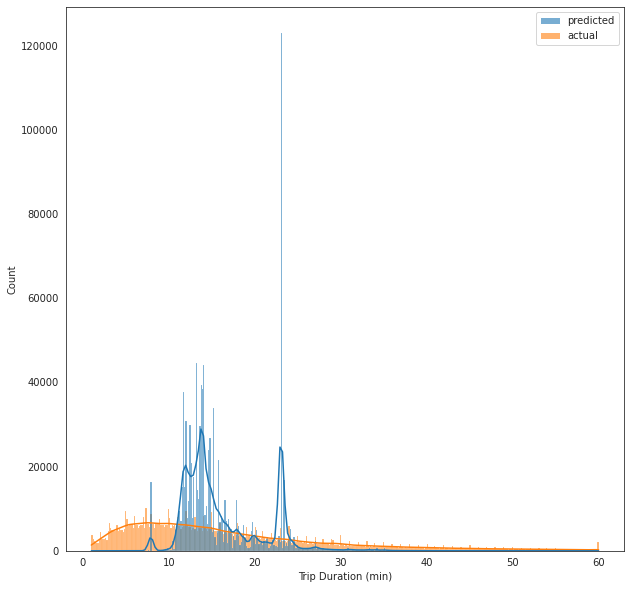

In [50]:

data = {"predicted": y_pred.squeeze(), "actual": y_val.squeeze()}
ax = sns.histplot(data, kde=True, alpha=0.6)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(10, 10)


Lasso

Getting more creative with our features we train our model with

In [51]:
def prep_dataset(df, categorical, numerical, target):
    print(f"Original data has {df.shape[0]} records.")

    df["trip_duration"] = calculate_trip_duration(df, "pickup_datetime", "dropOff_datetime")
    df["PUlocationID"] = df["PUlocationID"].fillna(-1)
    df["DOlocationID"] = df["DOlocationID"].fillna(-1)


    df["trip_route"] = df["PUlocationID"].astype(str) + "_" + df["DOlocationID"].astype(str)
    df["day_of_week"] = df["pickup_datetime"].dt.day_name()
    df["hour_of_day"] = df["pickup_datetime"].dt.hour

    df = df.loc[(df["trip_duration"]>=1) & (df["trip_duration"]<=60)].copy()

    if categorical:
        df[categorical] = df[categorical].astype(str)
    if numerical:
        df[numerical] = df[numerical].astype(float)

    print(f"Final data has {df.shape[0]} records.")

    return df

In [52]:
categorical = ["PUlocationID","DOlocationID", "trip_route","hour_of_day"]
numerical = None
target=["trip_duration"]

In [53]:
df_train = prep_dataset(
    df=download_parquet_to_df(year_month="2021-01", taxi_type="fhv"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 1154112 records.
Final data has 1109826 records.


In [54]:
df_val= prep_dataset(
    df=download_parquet_to_df(year_month="2021-02", taxi_type="fhv"),
    categorical= categorical,
    numerical = numerical,
    target= target)

Original data has 1037692 records.
Final data has 990113 records.


In [55]:
dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient="records")
val_dicts = df_val[categorical].to_dict(orient="records")


X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

y_train = df_train[target].values
y_val = df_val[target].values

In [56]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Our model is incorrect on average by {round(mse,3)} minutes")

Our model is incorrect on average by 10.504 minutes


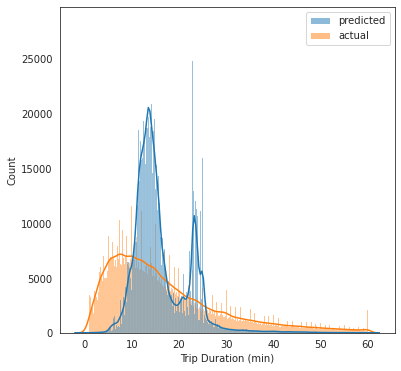

In [57]:
data = {"predicted": y_pred.squeeze(), "actual": y_val.squeeze()}
ax = sns.histplot(data, kde=True, alpha=0.5)
ax.set(xlabel="Trip Duration (min)")
ax.figure.set_size_inches(6, 6)